# ACD Models

**This notebook is written in python 3 **

Louis Echard - 42355

We want to use ACD like models to predict the information (tick) arrival time. 

The standard ACD Model looks like this :
$\psi(i) = \alpha_0 + \sum_{0<j=<p} \alpha_j x_{i-j} + \sum_{0=<j=<q} \beta_j \psi_{i-j}$

On which constraints exist.


We want to include shocks on the underlying and trade size in our model

Let's keep it for calls :
With K:Strike, F:Underlying

Moneyness : $ \omega  =  K/F$   

Shocks on the underlying : $ \lambda(F) = Time Weighted TradingVolumePastXTrades  $

Shocks on the Option : $ \lambda(O) =  Time Weighted TradingVolumePastXTrades $

dt : weighted time since volumes by volume

$\psi(i) = \alpha_0 + \sum_{1=<j=<p} \alpha_j log(x_{i-j}) + \sum_{0=<j=<q} \beta_j \psi_{i-j} + \sum_{0=<j=<s} \gamma_j \omega_{i-j} \lambda (O)_{i-j}   + \sum_{0=<j=<r} \delta_j \omega_{i-j} \lambda (U)_{i-j}$

As proposed by Bauwens and Giot (2000) we can take the logs to avoid constraints on the variables (keep stationarity)

In [5]:
#imports
import json
from pprint import pprint
import scipy.optimize as optimize
import pandas as pd
import numpy as np
from datetime import datetime
from enum import Enum
import sys
import timeit
import matplotlib.pyplot as plt
import datetime as dt
import calendar
from dateutil import tz
import gzip

In [2]:
#we need to preprocess the data
def getBookContract(aStringNumberContract, aTypeOption):
    aContract = ''
    if aStringNumberContract == "000" and aTypeOption == "1":
        aContract = CONTRACTTYPE.FUTURE #replace with enums
    elif aTypeOption == "2":
        aContract = CONTRACTTYPE.CALL 
    elif aTypeOption == "3":
        aContract = CONTRACTTYPE.PUT 
    else:
        print("error, Contract Type" + str(aStringNumberContract) + " , " + str(aTypeOption) + " not recognized")
    
    return aContract

class CONTRACTTYPE(Enum):
    UNSET = 0
    FUTURE = 1
    CALL = 2
    PUT = 3

In [3]:
#get the right time for plotting later
def utcToRightTMZ(aUTCTMZ):
    
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('Asia/Seoul')
    
    aUTCTMZ = aUTCTMZ.replace(tzinfo=from_zone)
    localTimeStamp = aUTCTMZ.astimezone(to_zone)
    
    return localTimeStamp

In [73]:
#load the data
#data = json.load(open('feeddata_10.json'))

#cleaner : keeps the file compressed on the computer
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data = json.loads(f.read().decode("ascii"))

In [74]:
#(datetime.utcfromtimestamp(data[0]["created"]/1000000))

# I. Typical ACD Model on Futures:
I didn't delete it, but this was a test, you can skip this part

In [75]:
#test of EACD on futures

def residualTotalEACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    
    p = pqs_[0]
    q = pqs_[1]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]    
    
    initialized = False
    first = True
    for idx, tick in enumerate(data):
    
        myBook = tick["book"]
           
        if myBook[5] == '1' and  tick['type']=='tick':   #let's forget about mini futures
            myContract = getBookContract(myBook[8:11],myBook[3])
    
            if myContract is CONTRACTTYPE.FUTURE:
                if initialized and not first :

                    #calculate alphas and betas parts
                    alphaSum = 0.0
                    betaSum = 0.0            
                    for idx2,alpha in enumerate(alphas): 
                        #print(xs)
                        alphaSum = alphaSum + alpha*xs[idx2] #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                    for idx2,beta in enumerate(betas):
                        #print(psis)
                        if len(psis)>idx2:
                            betaSum = betaSum + beta*psis[idx2]

                    expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                    psis.append(expectedTime)
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)


                    errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                    check1.append(expectedTime)
                    check2.append(xs[p])

                elif first:
                    first = False
                else:
                    xs.append((datetime.utcfromtimestamp(tick["created"]/1000000) - myPastTime).microseconds/1000)
                    if len(xs) == p:
                        initialized = True

                myPastTime = datetime.utcfromtimestamp(tick["created"]/1000000)

                #maintain right array size
                if len(xs)>p:
                    xs.pop(0)
                if len(psis)>q:
                    psis.pop(0)  

                if idx > 2000 :
                    break
    #return errs,check1,check2
    return np.average(errs)

In [76]:
#parameters:
alpha0 = 0.0
alphas = [1,1,1,1,1,1]
betas = [1,1,1,1]

params0 = [alpha0] + alphas + betas

### Test on Futures : LSE with constraints

In [77]:
def constraint1(x):
    return -np.sum(x)+len(x)

cons = (
            {'type': 'ineq',
             'fun' : constraint1
            }
          ,
              {'type': 'ineq',
               'fun' : lambda x: x
              }
        )

In [78]:

optimize.minimize(residualTotalEACD,params0,args=([len(alphas), len(betas)]), method='COBYLA', constraints=cons, options={'maxiter':10000})

     fun: 1987.1733927191476
   maxcv: 1.0135269667632516e-19
 message: 'Optimization terminated successfully.'
    nfev: 8687
  status: 1
 success: True
       x: array([  1.34372277e+00,  -9.46518187e-20,  -7.80014531e-21,
        -9.89682264e-20,  -9.51935771e-20,  -1.00768977e-19,
         2.65618311e-01,   3.67002166e-01,   7.79119699e-22,
         2.93608638e-01,  -1.01352697e-19])

In [79]:
# we just check what we would get with random variables
paramsTest = [1,1,1]

for idx,param in enumerate(paramsTest):
    paramsTest[idx] = paramsTest[idx]*(np.random.rand()*5)
print(residualTotalEACD(paramsTest, [len(alphas), len(betas)]))
print(paramsTest)

177630.040866
[3.8996560249952346, 4.994533817615261, 4.6851179353219985]


# II. New Model :

# Let's calculate the models for an option book, then we can compare the results to some benchmark

In [94]:
#dataExtraction to save calculation during optimization
#only taking the strike of interest and the future
#precalculating tick times

def extractInterestingData(nbOfDataPoints_, aOptionStrike,data_):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
            if tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.FUTURE: 
                myTicksOfInterest.append({'contractType' : CONTRACTTYPE.FUTURE,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                
            elif tick['type']=='lastdone' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'lastdone',
                                     'volume' : tick['volume'],
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
            elif tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({'contractType' : CONTRACTTYPE.CALL,
                                     'type' : 'tick',
                                     'received': datetime.utcfromtimestamp(tick['received']/1000000),
                                     'created' : datetime.utcfromtimestamp(tick['created']/1000000)
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest


In [95]:
#Simple EACD for Options
def residualTotalEACD(params_, pqs_):
    check1 = [] #sanity check
    check2 = [] #sanity check
    
    #variables of Interest:
    errs = [] #our squared errors
    psis = [] #our estimated waiting time
    xs = [] #the real waiting time
    
    
    p = pqs_[0] #number of lags for real waiting time used in calculation
    q = pqs_[1] #number of lags for estimated waiting time used in calculation
    
    alpha0 = params_[0] #constant
    alphas = params_[1:p+1] #parameters for real waiting time
    betas = params_[p+1:q+p+1] #parameters for estimated waiting time
    
    initialized = False # when we have enough lagged examples 
    first = True #the first data point has to be treated differently
    counter = 0 #the counter is just a check
    
    for idx, tick in enumerate(myDataForRun):
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0) #we keep the right size
            if len(psis)>q:
                psis.pop(0)  #we keep the right size
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that

                expectedTime = alpha0 + alphaSum +  betaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime) #sanity check
                check2.append(xs[p]) #sanity check

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0) #we keep the right size
        if len(psis)>q:
            psis.pop(0)  #we keep the right size


#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [96]:
#ACD model with added impact on current option book and underlying book
def residualTotalModACD(params_, pqs_):
    check1 = []
    check2 = []
    
    #variables of Interest:
    errs = []
    psis = []
    xs = []
    volumeO = []
    volumeF = []
    TO = []
    TF = []
    
    
    p = pqs_[0]
    q = pqs_[1]
    r = pqs_[2]
    s = pqs_[3]
    
    alpha0 = params_[0]
    alphas = params_[1:p+1]
    betas = params_[p+1:q+p+1]
    gammas =  params_[q+p+1:q+p+1+r]
    deltas = params_[q+p+r+1:q+p+r+s+1]
    
    initialized = False
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.FUTURE: 
            volumeF.append(tick['volume'])
            TF.append(tick['received'])
        if tick['type']=='lastdone' and tick['contractType'] is CONTRACTTYPE.CALL: 
            volumeO.append(tick['volume'])
            TO.append(tick['received'])
            
            
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
#               print('passed')
            if len(xs)>p:
                xs.pop(0)
            if len(psis)>q:
                psis.pop(0)  
            if len(volumeO)>r:
                volumeO.pop(0)
                TO.pop(0)
            if len(volumeF)>s:
                volumeF.pop(0)  
                TF.pop(0)
                
            if initialized and not first :
#                 print(counter)
                counter = counter + 1
                #calculate alphas and betas parts
                alphaSum = 0.0
                betaSum = 0.0
                gammaSum = 0.0 
                deltaSum = 0.0
                for idx2,alpha in enumerate(alphas): 
                    #print(xs)
                    alphaSum = alphaSum + alpha*np.log(xs[idx2]) #doesn't matter if sum in reverse order, just means that alphas are in reverse order too
                for idx2,beta in enumerate(betas):
                    #print(psis)
                    if len(psis)>idx2:
                        betaSum = betaSum + beta*psis[idx2] # our first estimation have to be thrown away when we do that
                for idx2,gamma in enumerate(gammas):
                        gammaSum = gammaSum + gamma*volumeO[idx2]*(tick['received']-TO[idx2]).microseconds/1000
                for idx2,delta in enumerate(deltas):
                        deltaSum = deltaSum + delta*volumeF[idx2]*(tick['received']-TF[idx2]).microseconds/1000

                expectedTime = alpha0 + alphaSum +  betaSum + gammaSum + deltaSum #expected time (psi)
                psis.append(expectedTime)
                xs.append((tick["created"] - myPastTime).microseconds/1000)


                errs.append((expectedTime - xs[p])*(expectedTime - xs[p]))
                check1.append(expectedTime)
                check2.append(xs[p])

            elif first:
                first = False
            else:
                xs.append((tick["created"] - myPastTime).microseconds/1000)
                #I forgot the logic, why do we append here ????
                if len(xs)>p:
                    xs.pop(0)
                if len(xs) == p and len(volumeO) == r and len(volumeF) == s:
#                         print("initialized sequenced")
                    initialized = True

            myPastTime = tick["created"]

            #maintain right array size
        if len(xs)>p:
            xs.pop(0)
        if len(psis)>q:
            psis.pop(0)  
        if len(volumeO)>r:
            volumeO.pop(0)
            TO.pop(0)
        if len(volumeF)>s:
            volumeF.pop(0)  
            TF.pop(0)

#             print(len(volumeO))
#         if counter > 200 :
#             break
    #return errs,check1,check2
    if len(errs)==0:
        sys.stderr.write("no run in function")
        return np.inf
    else :
        return np.mean(errs)

In [83]:
#@deprecated

# #parameters:
# alpha0 = 0.0
# alphas = [.01,.01,.01,.01,.01,.01]
# betas = [.01,.01,.01,.01]
# gammas = [.01,.01]
# deltas = [.01,.01]
# params0 = [alpha0] + alphas + betas + gammas + deltas
# #errs,check1,check2 = residualTotalEACD(params, len(alphas), len(betas))

# p = len(alphas)
# q = len(betas)
# r = len(gammas)
# s = len(deltas)

# alpha0 = params_[0]
# alphas = params_[1:p+1]
# betas = params_[p+1:q+p+1]
# gammas =  params_[q+p+1:q+p+1+r]
# deltas = params_[q+p+r+1:q+p+r+s+1]


In [217]:
nbOfDataPoints=3000

In [218]:
with gzip.open('data\\2017.11.01\\feeddata_10.json.gz', "rb") as f:
    data2017110110 = json.loads(f.read().decode("ascii"))

In [219]:
#extract interesting data, of x dataPoints for the specified strike

myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

In [220]:
#function giving initial parameters and parameters size for both ACD models
def initParams(isSimpleACD, isSize):
    alpha0 = 0.0
    alphas = [.001,.001,.001,.001,.001,.001]
    betas = [.001,.001,.001,.001]
    gammas = [.001,.001]
    deltas = [.001,.001]
    if not isSize:
        if isSimpleACD:
            return [alpha0] + alphas + betas
        else:
            return [alpha0] + alphas + betas + gammas + deltas
    elif isSize:
        if isSimpleACD:
            return [len(alphas), len(betas)]
        else:
            return [len(alphas), len(betas), len(gammas), len(deltas)]


In [221]:
#test of running time 1
start_time = timeit.default_timer()
print(residualTotalModACD(initParams(False, False),initParams(False, True)))
print(timeit.default_timer() - start_time)

6718.16877033
0.027984168986222357


In [222]:
#test of running time 2
paramsTest = initParams(False, False)
for i in range(0,20):
    for idx,param in enumerate(paramsTest):
        paramsTest[idx] = param*np.random.rand()*1.2
        start_time = timeit.default_timer()
        print(residualTotalModACD(paramsTest,initParams(False, True)))
        print("execution time in ms:",(timeit.default_timer() - start_time)*1000)


6718.16877033
execution time in ms: 28.05853077188658
6718.17152074
execution time in ms: 28.01123179960996
6718.15758751
execution time in ms: 27.7371903302992
6718.24749673
execution time in ms: 27.874698682353483
6718.32375593
execution time in ms: 28.678049789959914
6718.32896345
execution time in ms: 27.829350183310453
6718.40649062
execution time in ms: 27.820816863822984
6718.49294484
execution time in ms: 27.997334678730113
6718.48176447
execution time in ms: 28.756556332155014
6718.52355144
execution time in ms: 28.521768132122816
6718.5228222
execution time in ms: 27.617480041953968
6720.20761149
execution time in ms: 29.13397287557018
6718.57517068
execution time in ms: 28.225052414200036
6728.67173841
execution time in ms: 28.210911483256496
6775.84128024
execution time in ms: 27.879331057192758
6775.84128024
execution time in ms: 27.922241464693798
6775.90262107
execution time in ms: 28.93356176537054
6775.92907998
execution time in ms: 29.641827310115332
6775.92939033
exe

execution time in ms: 27.82788732838526
6907.76075939
execution time in ms: 28.20189054546063
6907.76075943
execution time in ms: 27.810576879346627
6907.76075963
execution time in ms: 27.993677540507633
6907.78822304
execution time in ms: 27.784733110820525
6907.78826729
execution time in ms: 27.93223763910646
6907.78826731
execution time in ms: 27.743529366489383
6907.78826731
execution time in ms: 27.80521307795425
6907.7882693
execution time in ms: 27.652344748275937
6907.78826929
execution time in ms: 27.70525133200863
6907.78826942
execution time in ms: 27.688428501278395
6907.78826947
execution time in ms: 27.902005305804778
6907.78827213
execution time in ms: 27.727681772375945
6907.78833922
execution time in ms: 27.74889316788176
6907.78833925
execution time in ms: 27.861532988026738
6907.78833932
execution time in ms: 27.86665298117441
6907.78833932
execution time in ms: 27.767422661781893
6907.78833935
execution time in ms: 27.670142817441956
6907.78833953
execution time in 

In [223]:
#benchmark n1 : 
#assume the next arrival time is equal to the last one
#e.g. we had to wait 10ms to get a new tick, we expect the next tick will come in 10ms
def residualSamePace() : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun): 
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
            
    return np.mean(errs)

#benchmark n2 : 
#assume the next arrival time is an exponential moving average of the last ones
def residualExpoMovingAverage(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(myDataForRun):
        if tick['type']=='tick' and tick['contractType'] is CONTRACTTYPE.CALL: 
            counter = counter + 1
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  > 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
            
    return np.mean(errs)

### evaluate benchmarks

In [224]:

#benchmark 1 : next tick arrives at same pace as the last
res_bench1_10 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1_10, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2_10 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the flat arrival time is :", res_bench2_10.fun, " with best solution x: ", res_bench2_10.x)


The squared errors for the flat arrival time is : 9165.69596874 



C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply


The squared errors for the flat arrival time is : 5799.129861051124  with best solution x:  [ 0.90730825]


In [225]:
#benchmark 3 : next tick arrives with EACD model
res_bench3_10 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5324.841356137033
     jac: array([-0.00201416,  0.00189209,  0.00268555, -0.00268555,  0.00305176,
        0.00073242, -0.00128174,  0.06115723, -0.04602051,  0.02313232,
        0.03289795])
 message: 'Optimization terminated successfully.'
    nfev: 914
     nit: 66
    njev: 66
  status: 0
 success: True
       x: array([ 0.07797459, -0.43128864,  1.74987552, -6.01700823, -2.52349263,
       -1.19280172,  8.63008568, -0.54785057,  0.79311569,  0.3707796 ,
        0.37626312])


In [226]:
res_ModACD_10 = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD_10)

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 5342.030770750242
     jac: array([  3.05175781e-04,  -2.31933594e-03,   4.82177734e-03,
        -2.50244141e-03,   4.15039062e-03,  -4.88281250e-04,
         2.99072266e-03,   5.52368164e-02,  -7.44628906e-03,
         5.82275391e-02,   6.10351562e-05,   5.80505371e-01,
         6.92626953e-01,   3.68688965e+00,  -3.34472656e-01])
 message: 'Optimization terminated successfully.'
    nfev: 1100
     nit: 61
    njev: 61
  status: 0
 success: True
       x: array([  2.44706826e+01,   2.92287726e-01,   3.42689325e+00,
         2.26281373e+00,   3.54420058e+00,   1.14820347e+01,
         8.96698453e+00,  -1.22344439e-01,   2.03879461e-01,
         3.56547302e-02,  -1.07080917e+00,   4.76548904e-03,
         1.40005239e-02,   1.39221772e-04,   9.02945036e-04])


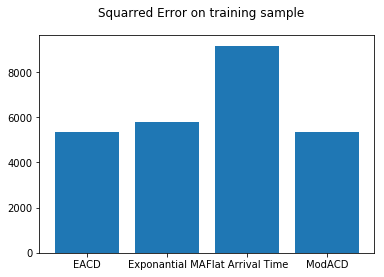

In [227]:
dataToPlot = {'Flat Arrival Time': res_bench1_10, 'Exponantial MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

The squared errors for the flat arrival time is : 3476.43734849 

The squared errors for the flat arrival time is : 

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:36: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:38: RuntimeWarning: overflow encountered in multiply
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:53: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:46: RuntimeWarning: invalid value encountered in double_scalars


2298.915947169761  with best solution x:  [ 0.60064909]
     fun: 1851.261397226359
     jac: array([ 0.00073242, -0.00563049,  0.00469971, -0.0057373 ,  0.00413513,
       -0.00372314,  0.0035553 ,  0.03240967,  0.00485229, -0.00944519,
       -0.00817871])
 message: 'Optimization terminated successfully.'
    nfev: 735
     nit: 53
    njev: 53
  status: 0
 success: True
       x: array([ 6.32253267,  0.2410081 , -2.0991684 ,  0.1753158 ,  1.73915648,
        2.07208888,  3.14091887,  0.85159355,  0.11067023, -0.13064207,
       -0.36373694])


C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:78: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: overflow encountered in double_scalars
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in double_scalars


     fun: 1822.0051264135705
     jac: array([ -5.49316406e-04,  -7.17163086e-04,  -2.59399414e-04,
         2.28881836e-04,  -9.30786133e-04,  -9.15527344e-05,
        -6.25610352e-04,  -5.26428223e-03,  -3.63159180e-03,
        -1.03149414e-02,  -1.40533447e-02,  -8.18283081e-01,
         2.92053223e-02,  -6.77185059e-02,  -3.42971802e-01])
 message: 'Optimization terminated successfully.'
    nfev: 835
     nit: 46
    njev: 46
  status: 0
 success: True
       x: array([  2.46285476e+01,   5.21709219e-01,   4.04734355e-01,
         1.87420941e+00,   3.41376920e+00,   2.92913613e+00,
         3.18007819e+00,   9.78344281e-02,  -1.93664727e-01,
        -5.42541709e-01,  -6.63397297e-01,   2.01239343e-03,
         4.89425024e-03,   3.88181876e-03,   3.70921505e-03])


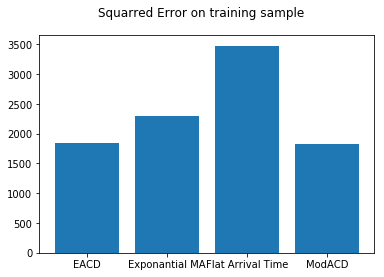

In [228]:
#testing on different window
with gzip.open('data\\2017.11.01\\feeddata_09.json.gz', "rb") as f:
    data2017110109 = json.loads(f.read().decode("ascii"))
    
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data11)

#benchmark 1 : next tick arrives at same pace as the last
res_bench1 = residualSamePace()
print("The squared errors for the flat arrival time is :",res_bench1, "\n")
#benchmark 2 : next tick arrives at an exponential moving average of the last infos with fitted param
res_bench2 = optimize.minimize(residualExpoMovingAverage,[1], method='SLSQP', options={'maxiter':30000})
print("The squared errors for the flat arrival time is :", res_bench2.fun, " with best solution x: ", res_bench2.x)

#benchmark 3 : next tick arrives with EACD model
res_bench3 = optimize.minimize(residualTotalEACD,initParams(True,False),args=(initParams(True,True)), method='SLSQP', options={'maxiter':30000})
print(res_bench3)
res_ModACD = optimize.minimize(residualTotalModACD,initParams(False,False),args=(initParams(False,True)), method='SLSQP', options={'maxiter':30000})
print(res_ModACD)

dataToPlot = {'Flat Arrival Time': res_bench1, 'Exponantial MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names = list(dataToPlot.keys())
values = list(dataToPlot.values())

fig, axs = plt.subplots()
axs.bar(names, values)
fig.suptitle('Squarred Error on training sample')

plt.show()

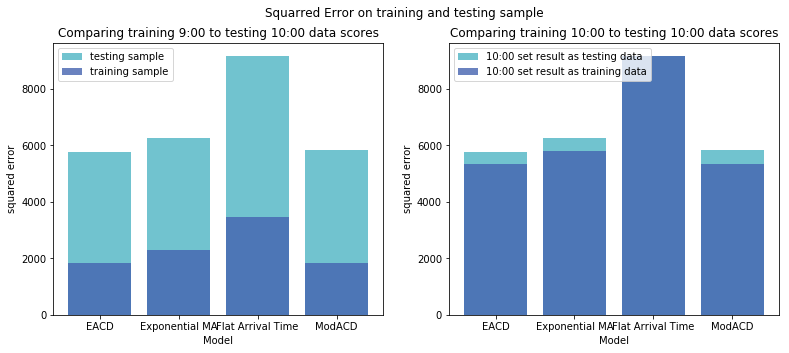

In [229]:
#let's test the data trained on 10am on the 09am set
myDataForRun = extractInterestingData(nbOfDataPoints,'335',data2017110110)

residualSamePace()

dataToPlot1 = {'Flat Arrival Time': residualSamePace(), 'Exponential MA': residualExpoMovingAverage(res_bench2.x), 'EACD': residualTotalEACD(res_bench3.x,initParams(True,True)), 'ModACD': residualTotalModACD(res_ModACD.x,initParams(False,True))}
names1 = list(dataToPlot1.keys())
values1 = list(dataToPlot1.values())

dataToPlot2 = {'Flat Arrival Time': res_bench1, 'Exponential MA': res_bench2.fun, 'EACD': res_bench3.fun, 'ModACD': res_ModACD.fun}
names2 = list(dataToPlot2.keys())
values2 = list(dataToPlot2.values())

dataToPlot3 = {'Flat Arrival Time': res_bench1_10, 'Exponential MA': res_bench2_10.fun, 'EACD': res_bench3_10.fun, 'ModACD': res_ModACD_10.fun}
names3 = list(dataToPlot3.keys())
values3 = list(dataToPlot3.values())

fig, axs = plt.subplots(1, 2, figsize=(13, 5))
axs[0].bar(names1, values1, color = "#139caf", alpha = 0.6, label = "testing sample")
axs[0].bar(names2,values2, color = '#4563b0', alpha = 0.8, label = "training sample")
axs[0].set_ylabel("squared error")
axs[0].set_xlabel("Model")
axs[0].set_title("Comparing training 9:00 to testing 10:00 data scores")
axs[0].legend(loc = 'upper left')

axs[1].bar(names1,values1, color = "#139caf" , alpha = 0.6, label = "10:00 set result as testing data")
axs[1].bar(names3, values3, color ='#4563b0' , alpha = 0.8, label = "10:00 set result as training data")
axs[1].set_ylabel("squared error")
axs[1].set_xlabel("Model")
axs[1].set_title("Comparing training 10:00 to testing 10:00 data scores")
axs[1].legend(loc = 'upper left')

fig.suptitle('Squarred Error on training and testing sample')

plt.show()

#### We can see that the testing sample has naturally more variance than the training sample (Flat Arrival Time is not being trained). We can however see that the EACD and Mod ACD fail to be very performant in comparison with a simpler model (exponential MA).

### Once we have performed a benchmark on the training set, we need to compare the benchmarks on a testing set

# Then we perform statistical tests on the soundness/robustness of our measures. 

# III. Exploratory Analysis :
What is the distribution of waiting time ?
What is the average waiting time for each time frame of the day ?
What is the sampling variance like ?
Is it changing a lot from day to day or is there consistencies ?

In [230]:
def extractOptionData(nbOfDataPoints_, aOptionStrike, data_):
    myTicksOfInterest = []
    myCounter = 0
    for idx, tick in enumerate(data_):
        myBook =tick["book"]
        if myBook[5] == '1':   #it as to be a MAXI
                    
            if tick['type']=='tick' and getBookContract(myBook[8:11],myBook[3]) is CONTRACTTYPE.CALL and myBook[8:11]==str(aOptionStrike):
                    myCounter = myCounter + 1
                    myTicksOfInterest.append({
                                     'received': utcToRightTMZ(datetime.utcfromtimestamp(tick['received']/1000000)),
                                     'created' : utcToRightTMZ(datetime.utcfromtimestamp(tick['created']/1000000))
                                    })
                    
        if myCounter >= nbOfDataPoints_:
            break
    return myTicksOfInterest

In [232]:
optionData = pd.DataFrame(extractOptionData(200000,335,data2017110110))

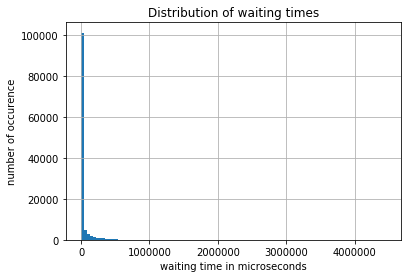

In [233]:
(optionData - optionData.shift())['created'].astype('timedelta64[us]').hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

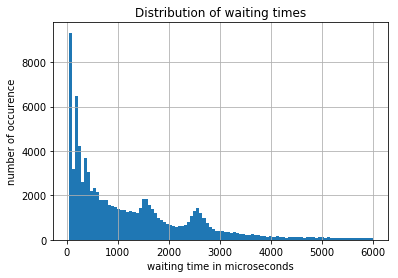

In [234]:
#closer look
dif = (optionData - optionData.shift()).astype('timedelta64[us]')
dif[dif['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

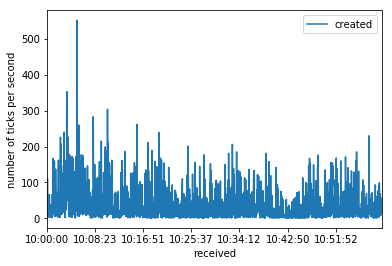

In [235]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M:%S',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per second')
plt.show()
#optionData2 = optionData2.mean(axis=1)

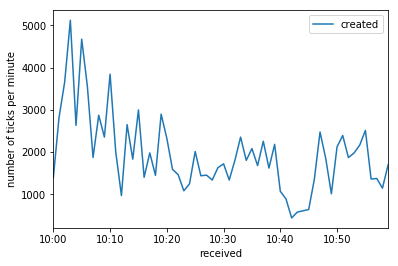

In [236]:
optionData2 = optionData.copy()
optionData2['received'] = optionData2['received'].apply(dt.date.strftime, args=('%H:%M',))

(optionData2.set_index('received')-optionData2.set_index('received').shift()).groupby(['received']).count().plot()
plt.ylabel('number of ticks per minute')
plt.show()

In [237]:
with gzip.open('data\\2017.11.01\\feeddata_13.json.gz', "rb") as f:
    data2017110113 = json.loads(f.read().decode("ascii")) 

In [242]:
optionData13 = pd.DataFrame(extractOptionData(200000,335,data2017110113))

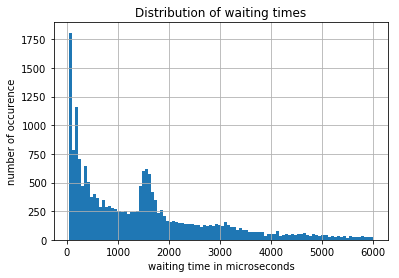

In [243]:
#closer look
dif13 = (optionData13 - optionData13.shift()).astype('timedelta64[us]')
dif13[dif13['created']<6000]['created'].hist(bins=100)
plt.title("Distribution of waiting times")
plt.ylabel('number of occurence')
plt.xlabel('waiting time in microseconds')
plt.show()

A few interesting phenomena to investigate : what is this spike of occurences at 1.5ms for both hours? 
Also, the market looks less busy at 13 than at 10. It makes sense.

In [246]:
def residualExpoMovingAverage13(aParam) : 
    errs = []
    first = True
    counter = 0
    for idx, tick in enumerate(extractOptionData(200000,335,data2017110113)):
        counter = counter + 1
        try:
            
            if not first:
                ArrivalTime = (tick["created"]-myFormerTime).microseconds/1000
                errs.append((ArrivalTime - ExpectedTime)*(ArrivalTime - ExpectedTime))
                myFormerTime = tick["created"]
                ExpectedTime = aParam*ExpectedTime +(1-aParam)*ArrivalTime
            else:
                if counter  == 2:
                    ExpectedTime = (tick["created"]-myFormerTime).microseconds/1000
                    first = False
            myFormerTime = tick["created"]
        except KeyError:
            print(tick)
            
    return np.mean(errs)

In [247]:
residualExpoMovingAverage13(res_bench2.x)

23632.943847811337

In [248]:
res_bench_test = optimize.minimize(residualExpoMovingAverage13,[res_bench2.x], method='SLSQP', options={'maxiter':30000})

C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in multiply
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Hal9000-ti\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: RuntimeWarning: overflow encountered in multiply
  del sys.path[0]


In [249]:
print(res_bench_test)

     fun: 23632.21706746082
     jac: array([ 0.00244141])
 message: 'Optimization terminated successfully.'
    nfev: 17
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([ 0.87905185])


In [250]:
print(res_bench2)

     fun: 3315.466151676504
     jac: array([-0.01916504])
 message: 'Optimization terminated successfully.'
    nfev: 28
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([ 0.88340882])


#### At first sight the results seem relatively robust, the error is not really different with the version trained on the testing set and the parameter value optimized on the two different sets is not so different. Again, we are just taking a single day with the 10:00-11:00 data as a training set and the 11:00-12:00 data as a testing set.